# Final project - Applied Mathematics


Members 
- José Manuel Tapia Avitia         A00834191
- Pablo César Ruíz Hernández       A01197044

In this python notebook we implemented several machine learning and statistical models to predict the inflation in Mexico, using the bi-weekly data recorded by INEGI.

### INEGI data
- INPC alogn with its components, extracted from [INEGI](https://www.inegi.org.mx/app/tabulados/default.aspx?nc=ca56_2018)
- INPC per city, extracted from [INEGI](https://www.inegi.org.mx/app/tabulados/default.aspx?nc=ca62_2018)
- INPC classifiying by object, extracted from [INEGI](https://www.inegi.org.mx/app/tabulados/default.aspx?nc=ca58_2018)

[Inflation calculator](https://www.inegi.org.mx/app/indicesdeprecios/calculadorainflacion.aspx)

[Price index](https://www.inegi.org.mx/app/indicesdeprecios/Estructura.aspx?idEstructura=112001300030&T=%C3%8Dndices%20de%20Precios%20al%20Consumidor&ST=Inflaci%C3%B3n%20Mensual)

[INEGI main page (check graphics)](https://www.inegi.org.mx/temas/inpc/#Informacion_general)

## Process data

### Libraries

In [ ]:
!pip install pystan==2.19.1.1 && pip install prophet

     |████████████████████████████████| 65 kB 4.3 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
     |████████████████████████████████| 214 kB 50.6 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639853 sha256=d1ea488cf7e2e646a2e4be74be4c0f5acae1a9e7ab435519619dd692f956f767
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk 
import tensorflow as tf
import warnings

from pandas.plotting import autocorrelation_plot
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### INEGI Dataframes

In [ ]:
# INEGI Data
inpc_components_link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSpdpTVzL6d_p4qhhkuVHxMMXIYKnITeyFtd98_e575z4MPiBtWdb8WKqmzXAlWYg/pub?gid=1239599080&single=true&output=csv'
inpc_per_city_link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTJ_JokBZWk1rFvOWK-frzbLo9cOw_IzyLkXyFbGejKytzyBkuoaUrz3ydCL5PH3A/pub?gid=988073853&single=true&output=csv'
inpc_per_objects_link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSTBQ9lwW-BX20fU8_wR0Ux2IzPTVe8yf6px5vFED9EzaijnzBKsjKn4jHRi2GEEQ/pub?gid=1466962329&single=true&output=csv'

# DataFrames
df_components = pd.read_csv(inpc_components_link)
df_city = pd.read_csv(inpc_per_city_link)
df_objects = pd.read_csv(inpc_per_objects_link)

# Parse dates
months = ['Ene', 'Feb', 'Mar', 'Abr', 
          'May', 'Jun', 'Jul', 'Ago', 
          'Sep', 'Oct', 'Nov', 'Dic']

def change_format_date(old_date):
  date_splitted = old_date.split(' ')
  day = '1' if date_splitted[0] == '1Q' else '15'
  month = str(months.index(date_splitted[1]) + 1)
  year = date_splitted[2]
  parsed_date = '-'.join([year, month, day])
  return parsed_date

df_components['Fecha'] = df_components['Fecha'].apply(lambda date: change_format_date(date))
df_city['Fecha'] = df_city['Fecha'].apply(lambda date: change_format_date(date))
df_objects['Fecha'] = df_objects['Fecha'].apply(lambda date: change_format_date(date))

## Statistical models

### Linear Regression

In [ ]:
def linear_regression(timeSerie, test_size=0.2):
  # Given a time serie, train a model that uses the position of time and 
  # previous value to predict the next values.
  #    f(t, x_t) -> x_{t+1}

  X = timeSerie.copy()
  y = X.copy()
  X.pop(0)
  y.pop()
  X = [[idx, x] for idx, x in enumerate(X)]
  X, y = np.array(X), np.array(y)
  
  # Train-test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size, 
                                                      shuffle=False)

  # Train model
  model = LinearRegression().fit(X_train, y_train)

  # Predict
  y_predict = model.predict(X_test)

  y_predict = []
  last_known_t, last_known_x = X_train[-1]
  for _ in range(len(X_test)):
    y_hat = model.predict(np.array([[last_known_t, last_known_x]], dtype=object))
    y_predict.append(y_hat)

    last_known_t += 1
    last_known_x = y_hat    

  return y_train, y_test, y_predict

### ARIMA

In [ ]:
def arima(timeSerie, test_size=0.2, order=(5, 1, 0)):
  # Given a time serie, train an ARIMA model to predict next values.
  X = timeSerie.copy()
  train_size_X = int(len(X) * (1 - test_size))
  
  # Train-test split
  X_train, X_test = X[:train_size_X], X[train_size_X:]

  # Train model, and predict
  y_predict = []
  history = X_train.copy()
  for _ in range(len(X_test)):
    model = ARIMA(np.array(history, dtype=object), order=order)
    model_fit = model.fit()
    
    y_hat = model_fit.forecast()[0]
    y_predict.append(y_hat)

    history.append(y_hat)
  return X_train, X_test, y_predict


### Prophet

In [ ]:
def prophet(timeSerie, dates, test_size=0.2, periods=365):
  X = timeSerie.copy()
  train_size_X = int(len(X) * (1 - test_size))

  # Train-test split
  X_train, X_test = X[:train_size_X], X[train_size_X:]
  dates_train, dates_test = dates[:train_size_X], dates[train_size_X:]

  # Train model
  df = pd.DataFrame({'ds': dates_train, 'y':X_train})
  model = Prophet()
  model.fit(df)

  # Predict
  future = model.make_future_dataframe(periods=len(X_test))
  forecast = model.predict(future)

  y_predict = forecast['yhat'].to_numpy(dtype=float)[-len(X_test):]
  y_predict_upper = forecast['yhat_upper'].to_numpy(dtype=float)[-len(X_test):]
  y_predict_lower = forecast['yhat_lower'].to_numpy(dtype=float)[-len(X_test):]
  """
  # Plotting prophet
  fig1 = model.plot(forecast)
  fig1.show()

  fig2 = model.plot_components(forecast)
  fig2.show()

  plot_plotly(model, forecast)
  plot_components_plotly(model, forecast)
  """
  return X_train, X_test, y_predict, y_predict_lower, y_predict_upper


## Machine Learning models


### Multi-Layer Perceptron


In [ ]:
def multi_layer_perceptron(timeSerie, look_back=10, test_size=0.2, epochs=100, verbose=False):  
  # Given a time serie, train a model that uses the last 'look_back' values 
  # to predict the next value. 
  #    f(x_{t-4}, x_{t-3}, x_{t-2}, x_{t-1}, x_{t}) -> x_{t+1}

  X, y = [], []
  for idx in range(len(timeSerie) - look_back):
    X.append(timeSerie[idx : idx + look_back])
    y.append(timeSerie[idx + look_back])
  X, y = np.array(X), np.array(y)

  # Train-test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size, 
                                                      shuffle=False)
  
  # Architecture of model
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(look_back,)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
  ])
  model.compile(loss=tf.keras.losses.mean_squared_error, 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mse', 'mae'])
  
  # Train model
  model.fit(X_train, y_train, 
            epochs=epochs,
            verbose=verbose)
  
  # Predict
  y_predict = []
  last_known_xs = X_train[-1]
  for _ in range(len(X_test)):
    y_hat = model.predict(np.array([last_known_xs]))
    y_predict.append(y_hat[0])
    last_known_xs = np.append(last_known_xs, y_hat[0])
    last_known_xs = np.delete(last_known_xs, 0)
    
  return y_train, y_test, y_predict

### Long Short Term-Memory

In [ ]:
def long_short_term_memory(timeSerie, look_back=10, test_size=0.2, batch_size=8, epochs=350, verbose=False):  
  # Given a time serie, train a model that uses the last 'look_back' values 
  # to predict the next value. 
  #    f(x_{t-4}, x_{t-3}, x_{t-2}, x_{t-1}, x_{t}) -> x_{t+1}

  X, y = [], []
  for idx in range(len(timeSerie) - look_back):
    x = timeSerie[idx : idx + look_back]
    X.append([[t] for t in x])
    y.append(timeSerie[idx + look_back])
  X, y = np.array(X), np.array(y)

  # Train-test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size, 
                                                      shuffle=False)
  
  # Architecture of model
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(look_back, 1)),
    tf.keras.layers.LSTM(5, activation='tanh'),
    tf.keras.layers.Dense(1)
  ])
  model.compile(loss=tf.keras.losses.mean_squared_error, 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mse', 'mae'])
  
  # Train model
  model.fit(X_train, y_train, 
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose)
  
  # Predict
  y_predict = []
  last_known_xs = X_train[-1]
  for _ in range(len(X_test)):
    y_hat = model.predict(np.array([last_known_xs]))
    y_predict.append(y_hat[0])
    last_known_xs = np.append(last_known_xs, y_hat)
    last_known_xs = np.delete(last_known_xs, 0)
    last_known_xs = [[x] for x in last_known_xs]
    
  return y_train, y_test, y_predict

## Bemnchark

### Plotting functions

In [ ]:
def particular_plot(dates_train, dates_test, y_train, y_test, y_predict=None, model_name='', ticks=10, suffix='', y_predict_lower=None, y_predict_upper=None):
  fig, ax = plt.subplots()
  # Plotting
  plt.ion()
  plt.plot(dates_train, y_train, color='red', label='Train')
  plt.plot(dates_test, y_test, color='blue', label='Test')

  plt.plot(dates_test, y_predict, color='green', label='Prediction')

  if y_predict_lower is not None:
    plt.plot(dates_test, y_predict_lower, color='yellowgreen', label='Lower limit')  

  if y_predict_upper is not None:
    plt.plot(dates_test, y_predict_upper, color='darkgreen', label='Upper limit')

  # Configuration
  plt.xlabel('Time')
  plt.ylabel('INPC')
  plt.title(model_name)
  
  inv_ticks = (len(dates_train) + len(dates_test) - 1)//ticks + 1
  ax.set_xticks(ax.get_xticks()[::inv_ticks])
  ax.tick_params(axis="x", labelrotation=-60)
  ax.legend()

  # Show
  plt.ioff()
  plt.savefig(f'{model_name}{suffix}.png', dpi=333, transparent=True)  
  fig.show()

def show_plots(dates, y_train, y_test, y_predict=None, model_name='', percentage_closeup=0.95, ticks_normal=12, ticks_closeup=10, y_predict_lower=None, y_predict_upper=None):
  dates_train = dates[:len(y_train)+1]
  dates_test = dates[len(y_train) : len(y_train) + len(y_test)]

  y_train_ = list(y_train)
  y_train_.append(y_test[0])
  particular_plot(dates_train, dates_test, 
                  y_train_, y_test, y_predict, 
                  model_name, ticks_normal, 
                  y_predict_lower=y_predict_lower, 
                  y_predict_upper=y_predict_upper)

  closer_point = int(len(dates_train) * percentage_closeup)
  dates_train_closeup = dates_train[closer_point:]
  y_train_closeup = y_train_[closer_point:]
  particular_plot(dates_train_closeup, dates_test, 
                  y_train_closeup, y_test, y_predict, 
                  model_name, ticks_closeup, suffix='_closeup', 
                  y_predict_lower=y_predict_lower, 
                  y_predict_upper=y_predict_upper)


### Plotting each model

In [ ]:
def get_series(days=None, biweeks=None):
  if biweeks is None:
    biweeks = days // 15 + 1 # Approximation of bi-weeks
  dates = df_components['Fecha'].to_numpy()[-biweeks:]
  timeSerie = list(df_components['INPC'].to_numpy())[-biweeks:]
  return timeSerie, dates

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as f

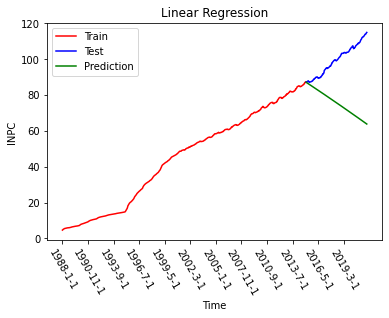

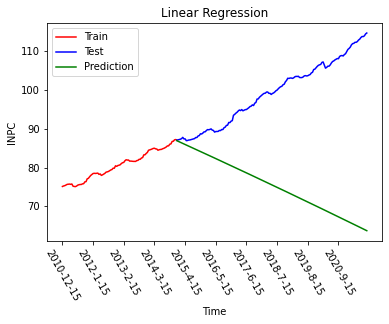

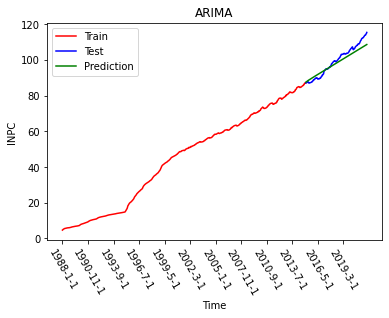

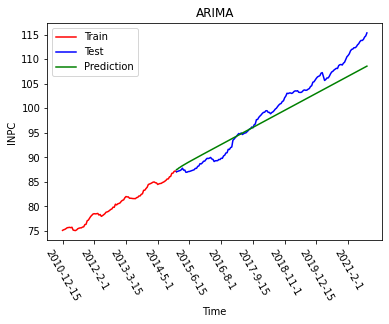

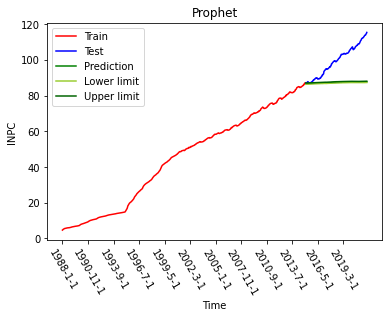

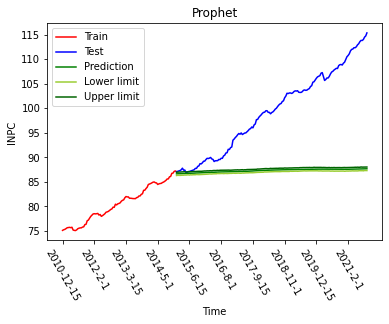

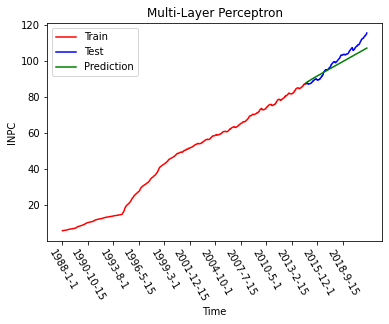

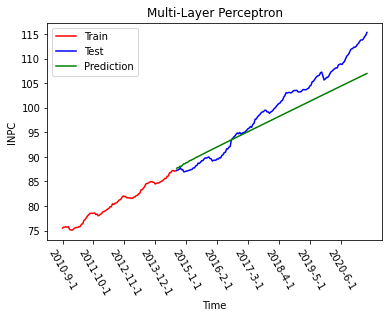

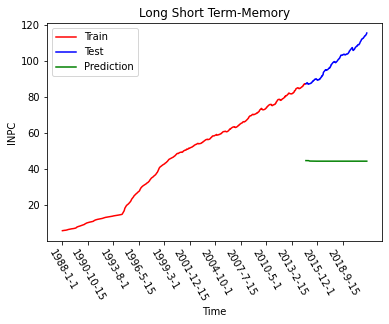

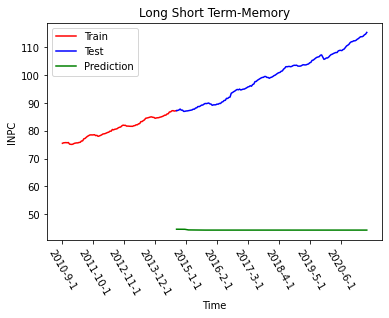

In [ ]:
timeSerie, dates = get_series(biweeks=len(df_components['Fecha'].to_numpy()))
## Linear regression
y_train_lr, y_test_lr, y_predict_lr = linear_regression(timeSerie)
show_plots(dates, y_train_lr, y_test_lr, y_predict_lr, 'Linear Regression', 0.85)

## ARIMA
y_train_ar, y_test_ar, y_predict_ar = arima(timeSerie)
show_plots(dates, y_train_ar, y_test_ar, y_predict_ar, 'ARIMA', 0.85)

## Prophet
y_train_fb, y_test_fb, y_predict_fb, y_predict_lower_fb, y_predict_upper_fb = prophet(timeSerie, dates)
show_plots(dates, y_train_fb, y_test_fb, y_predict_fb, 'Prophet', 0.85, y_predict_lower=y_predict_lower_fb, y_predict_upper=y_predict_upper_fb)

## MLP
y_train_mlp, y_test_mlp, y_predict_mlp = multi_layer_perceptron(timeSerie, epochs=200)
show_plots(dates, y_train_mlp, y_test_mlp, y_predict_mlp, 'Multi-Layer Perceptron', 0.85)

## LSTM
y_train_lstm, y_test_lstm, y_predict_lstm = long_short_term_memory(timeSerie, epochs=200)
show_plots(dates, y_train_lstm, y_test_lstm, y_predict_lstm, 'Long Short Term-Memory', 0.85)



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

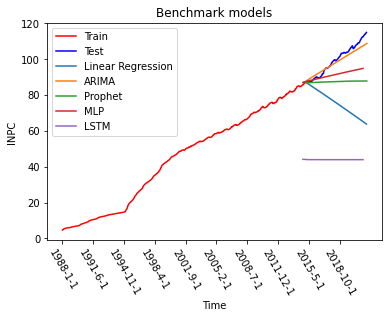

In [ ]:
fig, ax = plt.subplots()
# Plotting
plt.ion()

dates_train_lr = dates[:len(y_train_lr)]
dates_test_lr = dates[len(y_train_lr) : len(y_train_lr) + len(y_test_lr)]


plt.plot(dates_train_lr, y_train_lr, color='red', label='Train')
plt.plot(dates_test_lr, y_test_lr, color='blue', label='Test')


models_data = [
  [y_train_lr, y_test_lr, y_predict_lr, 'Linear Regression'],
  [y_train_ar, y_test_ar, y_predict_ar, 'ARIMA'],
  [y_train_fb, y_test_fb, y_predict_fb, 'Prophet'],
  [y_train_mlp, y_test_mlp, y_predict_mlp, 'MLP'],
  [y_train_lstm, y_test_lstm, y_predict_lstm, 'LSTM']
]

for y_train_model, y_test_model, y_predict_model, model_name in models_data:
  plt.plot(dates[len(y_train_model) : len(y_train_model) + len(y_test_model)], y_predict_model, label=model_name)

# Configuration
plt.xlabel('Time')
plt.ylabel('INPC')
plt.title('Benchmark models')

ticks = 10
inv_ticks = (len(dates_train) + len(dates_test) - 1)//ticks + 1
ax.set_xticks(ax.get_xticks()[::inv_ticks])
ax.tick_params(axis="x", labelrotation=-60)
ax.legend()

# Show
plt.ioff()
plt.savefig('benchmark_models.png', dpi=333, transparent=True)  
fig.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

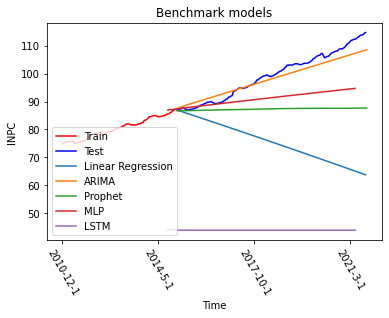

In [ ]:
fig, ax = plt.subplots()
# Plotting
plt.ion()

percentage_closeup=0.85
closer_point = int(len(y_train_lr) * percentage_closeup)
dates_train_lr = dates[closer_point:len(y_train_lr)]
dates_test_lr = dates[len(y_train_lr) : len(y_train_lr) + len(y_test_lr)]

y_train_ = list(y_train)
y_train_.append(y_test[0])

plt.plot(dates_train_lr, y_train_lr[closer_point:], color='red', label='Train')
plt.plot(dates_test_lr, y_test_lr, color='blue', label='Test')


models_data = [
  [y_train_lr, y_test_lr, y_predict_lr, 'Linear Regression'],
  [y_train_ar, y_test_ar, y_predict_ar, 'ARIMA'],
  [y_train_fb, y_test_fb, y_predict_fb, 'Prophet'],
  [y_train_mlp, y_test_mlp, y_predict_mlp, 'MLP'],
  [y_train_lstm, y_test_lstm, y_predict_lstm, 'LSTM']
]

for y_train_model, y_test_model, y_predict_model, model_name in models_data:
  plt.plot(dates[len(y_train_model) : len(y_train_model) + len(y_test_model)], y_predict_model, label=model_name)

# Configuration
plt.xlabel('Time')
plt.ylabel('INPC')
plt.title('Benchmark models')

ticks = 10
inv_ticks = (len(dates_train) + len(dates_test) - 1)//ticks + 1
ax.set_xticks(ax.get_xticks()[::inv_ticks])
ax.tick_params(axis="x", labelrotation=-60)
ax.legend()

# Show
plt.ioff()
plt.savefig('benchmark_models_closeup.png', dpi=333, transparent=True)  
fig.show()

In [ ]:
dates_train_lr[-1]

'2014-12-15'

In [ ]:
y_predict_lstm

[array([44.035786], dtype=float32),
 array([44.033333], dtype=float32),
 array([44.03333], dtype=float32),
 array([44.033318], dtype=float32),
 array([44.033245], dtype=float32),
 array([44.03281], dtype=float32),
 array([44.030003], dtype=float32),
 array([44.013508], dtype=float32),
 array([43.951206], dtype=float32),
 array([43.893143], dtype=float32),
 array([43.886185], dtype=float32),
 array([43.8837], dtype=float32),
 array([43.88119], dtype=float32),
 array([43.878662], dtype=float32),
 array([43.87612], dtype=float32),
 array([43.873623], dtype=float32),
 array([43.87132], dtype=float32),
 array([43.86959], dtype=float32),
 array([43.868713], dtype=float32),
 array([43.868336], dtype=float32),
 array([43.86805], dtype=float32),
 array([43.867805], dtype=float32),
 array([43.867603], dtype=float32),
 array([43.867443], dtype=float32),
 array([43.867317], dtype=float32),
 array([43.867233], dtype=float32),
 array([43.86718], dtype=float32),
 array([43.867146], dtype=float32),
 a

In [ ]:
timeSerie, dates = get_series(biweeks=54)
plot_models(timeSerie, dates)

In [ ]:
from scipy.stats import pearsonr, spearmanr


def calculate_errors(y_predict, y_test):
  if  isinstance(y_predict[0], np.ndarray):
    y_predict = [ x[0] for x in y_predict ]
  covariance = np.cov(y_predict, y_test)
  corr, _ = pearsonr(y_predict, y_test)
  corr_2, _ = spearmanr(y_predict, y_test)
  return mean_squared_error(y_test, y_predict),covariance[0][1], corr, corr_2


print("""
\\begin{table}[H]
\\centering
\\begin{tabular}{|l|r|r|r|r|}
\\hline
\\multicolumn{1}{|c|}{\\textbf{Models}} & \\multicolumn{1}{c|}{\\textbf{Mean Square Error}} &  \\multicolumn{1}{c|}{\\textbf{Covariance}}  & \\multicolumn{1}{c|}{\\textbf{\\begin{tabular}[c]{@{}c@{}}Pearson\\\\ correlation\\end{tabular}}}   &    \\multicolumn{1}{c|}{\\textbf{\\begin{tabular}[c]{@{}c@{}}Spearman\\\\ correlation\\end{tabular}}}               \\\\ \hline
""")

for _, y_test_model, y_predict_model, model_name in models_data:
  mse, cov, pearson, spearman_c = calculate_errors(y_predict_model, y_test_model)
  print("{} & {:.4f} & {:.4f} & {:.4f} & {:.4f}".format(model_name, mse, cov, pearson, spearman_c), end='\\\\ \\hline\n')

print(""" 
\\end{tabular}
\\caption{Benchmark results}
\\label{table:benchmark}
\\end{table}
""" )


\begin{table}[H]
\centering
\begin{tabular}{|l|r|r|r|r|}
\hline
\multicolumn{1}{|c|}{\textbf{Models}} & \multicolumn{1}{c|}{\textbf{Mean Square Error}} &  \multicolumn{1}{c|}{\textbf{Covariance}}  & \multicolumn{1}{c|}{\textbf{\begin{tabular}[c]{@{}c@{}}Pearson\\ correlation\end{tabular}}}   &    \multicolumn{1}{c|}{\textbf{\begin{tabular}[c]{@{}c@{}}Spearman\\ correlation\end{tabular}}}               \\ \hline

Linear Regression & 785.9170 & -55.7715 & -0.9943 & -0.9970\\ \hline
ARIMA & 7.0250 & 50.5518 & 0.9938 & 0.9970\\ \hline
Prophet & 208.0262 & 2.4799 & 0.9514 & 0.9696\\ \hline
MLP & 108.7969 & 18.5881 & 0.9937 & 0.9971\\ \hline
LSTM & 3152.8411 & -0.1140 & -0.3798 & -0.7256\\ \hline
 
\end{tabular}
\caption{Benchmark results}
\label{table:benchmark}
\end{table}

